#  Stochastic Optimal Control Tutorial
## Introduction: Hamilton-Jacobi-Bellman Equation
In optimal control theory, the Hamilton–Jacobi–Bellman (HJB) equation gives a necessary and sufficient condition for optimality of a control with respect to a loss function. It is, in general, a nonlinear partial differential equation in the **value function** $V$, which means its solution is the value function itself. Once this solution is known, it can be used to obtain the **optimal control** $u$ by taking the maximizer (or minimizer) of the Hamiltonian involved in the HJB equation. 

A **stochastic optimal control** (SOC) problem is defined by minimizing the expected cost functional (or maximizing a gain function) $J$ as the following
$$
V(t,x) := \inf_{u \in \mathcal{U}[0,T]} J(u) = \inf_{u \in \mathcal{U}[0,T]} \mathbb{E} \left[ \int_0^T f(x(t),u(t)) \ \mathrm{d}t +  g(x(T)) \right],
$$
where $V(t,x):=\inf_{u \in \mathcal{U}[0,T]} J(u)$ is the value function, $x$ and $u$ are the state and control variables, respectively, $f$ is the running cost and $g$ is the terminal cost functions and $\mathcal{U}$ is the set of all admissible controls. The state variables $x$ are the solutions of the controlled drift-diffusion stochastic process given the initial conditions $x(0) = \xi$
$$
\mathrm{d}x(t) = b(x(t), u(t)) \mathrm{d}t + \Sigma(x(t), u(t)) \mathrm{d}W(t), \quad x(0) = \xi,
$$
where $b$ is a nonlinear vector-valued drift function, $\Sigma$ is the diffusion matrix and $W$ is a vector of mutually independent Brownian motions. Using the definition of value function and from Bellman's [Principal of Optimality](https://en.wikipedia.org/wiki/Bellman_equation), the HJB equation can be derived as a nonlinear partial differential equation (PDE) for $V$ as
$$
V_t + \inf_{u \in \mathcal{U}[0,T]} \mathcal{H}(x, u, V_x, V_{xx}) = 0, \\ 
V(T,x) = g(x),
$$
where $\mathcal{H}$ is known as the **Hamiltonian** and is written as
$$
\mathcal{H}(x, u, V_x, V_{xx}) \triangleq \frac{1}{2} \mathrm{Tr} (V_{xx}\Sigma \Sigma^T) + V_x^T b(x,u) + f(x,u),
$$
where $V_x$ is the gradient and $V_{xx}$ is the Hessian of value function, `Tr` is the matrix trace operator and `T` is the matrix transpose.

## Equation-informed Deep Learning of SOC

Given that a solution $u^{\ast}$ (known as the optimal control) to the minimization of $\mathcal{H}$ exists, the unique solution of the HJB equation corresponds by virtue of the nonlinear **Feynman-Kac lemma** to the system of forward-backward stochastic differential equations (FBSDE) as the following
$$
x(t) = \xi + \int_0^T b(x(t), u^{\ast}(t)) \ \mathrm{d}t + \int_0^T \Sigma(x(t), u^{\ast}(t)) \ \mathrm{d}W_t, \quad \mathrm{forward} \\
V(t, x(t)) = g(x(T)) + \int_t^T f(x(t), u^{\ast}(t)) \ \mathrm{d}t - \int_t^T V^T(t, x(t)) \Sigma(x(t), u^{\ast}(t)) \ \mathrm{d}W_t, \quad \mathrm{backward} \\
u^{\ast}(t) = \underset{u}{\mathrm{argmin}} \ \mathcal{H}\left( x(t), u, V_x(t,x(t)), V_{xx}(t,x(t) \right).
$$
Here, $V(t, x(t))$ is the evolution of value function along a path of $x(t)$ thus, $V(t, x(t))$ is a stochastic process (similarly for $V_x$ and $V_{xx}$). While $x(t)$ evolves forward in time due to its initial condition $\xi$, $V(t, x(t))$ evolves backward in time due to its terminal condition $g(x(T))$. As a result, solving such a coupled system is not straight-forward.

One may use an *iterative* way to address such problem i.e., first, solve for $V(t, x(t))$ starting from an initial condition guess $V(0, x(t))$. Then, compare its terminal value $V(T, x(T))$ to the terminal condition, and adjust the initial condition accordingly such that the terminal condition is approximately satisfied. This fits easily into the deep learning framework as neural networks can approximate any function such as $V(t, x(t))$ in this case. Furthermore, any adjustment to the initial guess for $V$ can be achieved by minimizing a proper `loss` function. A generic algorithm to solve the FBSDE problem using equation-informed deep learning is given below.

<img src="./figures/DeepFBSDE-generic.PNG" alt="drawing" width="500"/>

---

## Inverted Pendulum Problem

In this tutorial, we aim to solve the classic Inverted Pendulum control problem by solving the FBSDE equations. The goal is to apply torque (i.e., the control) such that the pendulum stays in the upright position. This problem can be solved using conventional policy gradient methods such as deep deterministic policy gradient (DDPG). A solution of this control problem using DDPG algorithm and [OpenAIGym](http://gym.openai.com/envs/Pendulum-v0/) environment is provided in this [notebook](). Note that the gym environment provides deterministic observations for the pendulum problem. To make the problem stochastic, we have added noise to pendulum velocity in a new gym environment `gym_StochPendulum` that must be installed first. Furthermore, to render and view the pundulum swing as a video, a few packages must be installed and a utility function to show the video is provided for that purpose.

In [1]:
# !pip install gym > /dev/null 2>&1
# !pip install -e gym-StochPendulum > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import numpy as np
import numpy.random as npr

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import autograd

from time import time

from tqdm import trange

import gym
import gym_StochPendulum
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)              # error only

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math

from os import path
import glob
import io
import base64
import ipywidgets as widgets
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, run "env = wrap_env(env)""
"""
def show_video(path_to_video):
    if path.exists(path_to_video):
        mp4 = path_to_video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii'))))
    else:
        print('Video cannot be found...')

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [3]:
widget1 = widgets.Output()
widget2 = widgets.Output()

with widget1:
    show_video('./video/openaigym-pendulum.mp4')
with widget2:
    show_video('./video/pendulum-phase-space.mp4')

display(widgets.HBox([widget1, widget2]))

### Problem setup

The state of the pendulum at any time can be dexcribed by $x=(\theta, \dot{\theta})$, where $\theta$ is radial position and $\dot{\theta}$ is angular velocity of pendulum. Integrating the equations of motion for pendulum, we obtain the state of the pendulum $x(t)$ at any time
$$
\theta_{n+1} = \theta_n + \dot{\theta}_n \Delta t, \\
\dot{\theta}_{n+1} = \dot{\theta}_n + \left(\frac{u}{I} - \frac{b}{I} \dot{\theta}_n - \frac{g}{l} \mathrm{sin}(\theta_n)\right) \Delta t + \sigma \Delta W_n,
$$
where `l` is pendulum arm length, $I=ml^2$ is pendulum inertia with `m` as its mass, $g=10$ is the gravitational acceleration, `b` is pendulum damping coefficient, `u` is the applied torque or the control to swing the pundulum, $\sigma$ is the level of noise added to pendulum velocity and $\Delta W_n=\sqrt{\Delta t} \mathcal{N}(0,1)$ is the Brownian noise increment. These paramaters are set in the `Config` class below. In addition, same parameters are used in `gym_StochPendulum` environment so we can validate the model predictions after training the neural network. Note that to prevent unrealistically high values, the torque and pendulum velocity are clipped above a certain threshold.

There are two types of costs, namely, the control cost in the form of $0.5 R u^2$ and the state cost as $0.5 Q (x-x^{target})^2$. The algorithm tries to minimize their sum through the swing process. Here, `R` and `Q` are cost function parameters, and the target state $x^{target} = (\pi, 0)$ is the state in which the controller wants the pendulum to be (i.e., upright position at $\theta=\pi$ and zero angular velocity).

In addition to the running cost, there is a terminal cost at the end of each episode that should be accounted for. The terminal cost is computed similar to the state cost at terminal time i.e., $0.5 Q \left(x(T)-x^{target}\right)^2$.

### Optimal control
The quadratic costs lead to a linear quadratic Hamiltonanian for which the minimizer i.e., the optimal control $u^{\ast}$ can be analytically derived. To find the optimal control, we take the gradient of hamiltonian with respect to `u` and set it to zero i.e., $\partial \mathcal{H} / \partial u = 0$. This equation can be solved analytically to obtain optimal control
$$
u^{\ast}(t, x(t)) = -\frac{1}{R} G^T V_x(t, x(t))
$$
where `G` represents the control dynamics (is known) and $V_x$ is the gradient of the value function.

In [4]:
""" Class for neural network and pendulum environment parameters """
class Config(object):
    """ neural network and optimizer-related parameters """
    batch_size = 128
    logging_frequency_valid = 10    # frequency of validation
    clip_norm = True                # whether clip the gradient of the loss function
    max_gradient_norm = 1.
    random_seed = 1234
    n_hidden = 32                   # number of neurons in hidden layers
    verbose = True
    
    """ number of steps and terminal time """
    n_state = 2
    T_terminal = 10.
    n_timestep = 200
    """ pendulum parameters """
    max_speed = 8.                  # clip values of angular velocity beyond the threshold
    max_torque = 10.                # clip values of torque (control) beyond the threshold
    g = 10.                         # gravitational acceleration
    m = 2.                          # pendulum mass
    l = 0.5                         # pendulum arm length
    b = 0.1                         # pendulum damping coefficient
    I = m * l**2                    # pendulum inertia
    sigma = [0., 1.]                # level of noise added to the pendulum state variables
    R = 0.1                         # control cost parameter
    Q = [4., 0.05]                  # state cost parameter
    G = [0., 1./I]                  # controller dynamics parameter
    target = [np.pi, 0.]            # target state [upright poisiton, zero velocity]
    init_state = [0., 0.]           # initial state for training episodes
    
    use_gpu = False
    if use_gpu:
        device = 'cuda:0'
    else:
        device = 'cpu'

---
## Model Implementation

In [5]:
""" Setup a feed-forward neural network by subclassing using PyTorch framework """
class HJBNet(nn.Module):
    def __init__(self, n_in: int, n_out: int, n_hidden: int=256):
        super().__init__()
        """ contains 3 layers with softplus activation """
        self.HJB_net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_out)
        )
        
    def forward(self, t, x):
        z = torch.cat((t, x), dim=-1)
        return self.HJB_net(z)

In [6]:
""" Create an environment class for pendulum with the necessary methods to 
compute the quantities of interest such as the costs and also integrate the FBSDE equations """
class PendulumEnv():
    def __init__(self, cfg):
        self.g = cfg.g                    # gravitational acceleration
        self.m = cfg.m                    # pendulum mass
        self.l = cfg.l                    # pendulum arm length
        self.b = cfg.b                    # pendulum damping coefficient
        self.I = cfg.I                    # pendulum inertia
        self.max_speed = cfg.max_speed    # maximum pendulum speed
        self.max_torque = cfg.max_torque  # maximum applied torque (control)
        
        self.device = cfg.device
        
        self.sigma = torch.Tensor( np.diag(cfg.sigma) ).to(self.device)         # Gaussian noise added to pendulum velocity
        self.R = torch.Tensor( np.array([[cfg.R]]) ).to(self.device)            # control cost parameter
        self.Q = torch.Tensor( np.array([cfg.Q]) ).to(self.device)              # state cost parameter
        self.target = torch.Tensor( np.array([cfg.target]) ).to(self.device)    # target state to achieve
        self.G = torch.Tensor( np.array([cfg.G]) ).to(self.device)              # controller dynamics parameter
    
    """ running cost function """
    def cost(self, x, u): # M x D, M x 1
        batch_size = x.shape[0]
        Q = self.Q.repeat(batch_size, 1) # M x D
        target = self.target.repeat(batch_size, 1)
        R = self.R.repeat(batch_size, 1)

        state_cost = 0.5 * (Q*(x-target)**2).sum(dim=1, keepdim=True)
        control_cost = 0.5 * R * u**2
        return state_cost + control_cost # M x 1
    
    """ terminal cost function """
    def terminal_cost(self, x): # M x D
        batch_size = x.shape[0]
        Q = self.Q.repeat(batch_size, 1)
        target = self.target.repeat(batch_size, 1)
        return 0.5 * (Q*(x-target)**2).sum(dim=1, keepdim=True) # M x 1
    
    """ gradient of terminal cost with respect to state x, which is analytically derived """
    def grad_terminal_cost(self, x): # M x D
        batch_size = x.shape[0]
        Q = self.Q.repeat(batch_size, 1)
        target = self.target.repeat(batch_size, 1)
        return Q * (x-target) # M x D
    
    """ drift term """
    def b_(self, x, u): # M x D, M x 1
        F = (-self.b/self.I)*x[:,1:2] - (self.g/self.l)*torch.sin(x[:,0:1])
        b0 = x[:,1:2].clone()
        b1 = F + u/self.I
        return torch.cat((b0, b1), dim=-1) # M x D
        
    """ standard deviation of the noise """
    def sigma_(self, batch_size):
        sigma_l = batch_size * [self.sigma]
        return torch.stack(sigma_l, dim=0) # M x D x D
    
    """ function to compute the optimal control from the analytic equation """
    def optimal_control(self, v_x): # M x D
        batch_size = v_x.shape[0]
        R = self.R.repeat(batch_size, 1) # M x 1
        G = self.G.repeat(batch_size, 1) # M x D
        return -torch.div(1., R) * (G*v_x).sum(dim=1, keepdim=True) # M x 1
    
    def step(self, dt, dW, x, v, v_x): # M x 1, M x D, M x D, M x 1, M x D
        batch_size = x.shape[0]
        sigma_dW = torch.matmul(self.sigma_(batch_size), dW.unsqueeze(dim=-1)).squeeze(dim=-1)
        
        u_opt = self.optimal_control(v_x) # M x 1
        u_opt = torch.clamp(u_opt, -self.max_torque, self.max_torque)
        
        h = self.cost(x, u_opt) # M x 1   running cost
        
        """ integrate the sde for state x """
        def forward_sde():
            return x + self.b_(x, u_opt)*dt + sigma_dW
        
        """ integrate the sde for the value function """
        def backward_sde():
            return v - h*dt + (v_x*sigma_dW).sum(dim=1, keepdim=True)
        return forward_sde(), backward_sde(), h, u_opt

In [7]:
""" Main class for streaming data, neural network training and model inference """
class DeepFBSDE():
    def __init__(self, cfg):
        self.cfg = cfg
        torch.manual_seed(self.cfg.random_seed)
        npr.seed(self.cfg.random_seed)
        self.cost_history = []                  # cost function is computed at every timestep; good controller must achieve smaller cost for the episode
        self.loss_history = []                  # Adam optimization is directly applied to the loss function
        
        self.T = self.cfg.T_terminal            # final time of the episode
        self.M = self.cfg.batch_size            # batch size
        self.N = self.cfg.n_timestep            # number of steps in the episode
        self.D = self.cfg.n_state               # number of state variables
        
        self.max_speed = self.cfg.max_speed
        self.max_torque = self.cfg.max_torque
        self.g = self.cfg.g
        self.m = self.cfg.m
        self.l = self.cfg.l
        self.init_state = self.cfg.init_state   # initial state of the episode for training
        
        self.device = torch.device(self.cfg.device)
        
        print('Using Pendulum environment')
        self.env = PendulumEnv(self.cfg)
        
        print(f'Using a batch size of {self.M} episodes')
        self.Vnet = HJBNet(n_in=self.D+1, n_out=1, n_hidden=self.cfg.n_hidden).to(self.device)
        
        print('\nModel trainable paramaters:')
        for name, param in self.Vnet.named_parameters():
            if param.requires_grad:
                print(name, ', shape:', list(param.shape))
        print('\n')
    
    """ reset at the beginning of each episode by setting the state initial conditions """
    def reset(self, batch_size):
        high = np.repeat(np.array([self.init_state]), batch_size, axis=0)
        Xi = npr.uniform(low=-high, high=high)
        return Xi            # x(0)

    """ the neural network takes the state as input and outputs value function
    using PyTorch autograd the gradient of value function is also computed """
    def net_v_z(self, t, x): # M x 1, M x D
        v = self.Vnet(t, x)  # M x 1
        z = autograd.grad(outputs=v, inputs=x, grad_outputs=torch.ones_like(v), create_graph=True)[0] # M x D
        return v, z          # V and V_x
        
    """ to compute the loss, the system of FBSDE for the state and value function must be integrated forward
    in time up to the terminal time at which point we are able to compute the loss """
    def loss_function(self, t, Xi, W):
        """ keep track of states, value function and optimal control through the episodes """
        cost_tot = 0
        X_list = []
        Y_list = []
        U_list = []
        
        t0 = t[:,0,:]                 # M x 1
        W0 = W[:,0,:]                 # M x D
        X0 = Xi                       # M x D
        Y0, Z0 = self.net_v_z(t0, X0) # output: M x 1, M x D
        
        X_list.append(X0)             # keep track of states through the episode
        Y_list.append(Y0)             # keep track of value function through the episode
        
        for n in range(0, self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            dt = t1 - t0
            dW = W1 - W0
            
            X1, Y1, cost, U_opt = self.env.step(dt, dW, X0, Y0, Z0)    # take one step forward
            
            _, Z1 = self.net_v_z(t1, X1)                               # take gradient of V using autograd

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            
            cost_tot += cost.mean()   # keep track of the cost through the episode
            X_list.append(X0)
            Y_list.append(Y0)
            U_list.append(U_opt)      # keep track of the optimal control through the episode
            
        """ compute the loss at the end of the episode by comparing with target V and V_x """
        loss = F.mse_loss(input=Y1, target=self.env.terminal_cost(X1.detach())) + \
               F.mse_loss(input=Z1, target=self.env.grad_terminal_cost(X1.detach()))

        X = torch.stack(X_list, dim=1).squeeze()
        Y = torch.stack(Y_list, dim=1).squeeze()
        U = torch.stack(U_list, dim=1).squeeze()
        return loss, cost_tot, X, Y, U
        
    """ prepare input training data as a batch of episodes of size M and duration T """
    def fetch_batch(self, batch_size):
        T = self.T
        M = batch_size
        N = self.N
        D = self.D
        
        Dt = np.zeros((M, N+1, 1))
        DW = np.zeros((M, N+1, D))
        Xi = self.reset(batch_size)
        
        dt = T / N
        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt) * npr.normal(size=(M, N, D))
        
        """ compute timestep size and Brownian increments that are needed for solving system of FBSDE """
        t = np.cumsum(Dt, axis=1) # M x (N+1) x 1
        W = np.cumsum(DW, axis=1) # M x (N+1) x D
        
        t_batch = torch.as_tensor(t, dtype=torch.float, device=self.device).requires_grad_(True)
        Xi_batch = torch.as_tensor(Xi, dtype=torch.float, device=self.device).requires_grad_(True)
        W_batch = torch.as_tensor(W, dtype=torch.float, device=self.device).requires_grad_(True)
        return t_batch, Xi_batch, W_batch
    
    def train_loop(self, n_epoch, init_lr_value, fixed_lr=True, l2_reg=0.):
        """ Adam optimizer with l2 regularization """
        opt = optim.Adam(params=[{'params': self.Vnet.parameters()}], lr=init_lr_value, weight_decay=l2_reg)
        """ setup the learning rate scheduler """
        if fixed_lr:
            print('Using a fixed learning rate of:', init_lr_value)
            lr_sched = ReduceLROnPlateau(opt, 'min', patience=1000, factor=0.9999, verbose=True)
        else:
            lr_sched = ReduceLROnPlateau(opt, 'min', patience=3, factor=0.75, verbose=True)
        
        pbar = trange(n_epoch)                                                   # each epoch is considered as going through one batch of episodes
        for epoch in pbar:
            iter_start_time = time()
            t_batch, Xi_batch, W_batch = self.fetch_batch(batch_size=self.M)     # get the batch of episodes
            loss, _, _, _, _ = self.loss_function(t_batch, Xi_batch, W_batch)    # compute MSE for the batch of episodes
            opt.zero_grad()
            loss.backward(retain_graph=True)                                     # compute the gradient of loss
            if self.cfg.clip_norm:                                               # clip the gradients above a threshold
                nn.utils.clip_grad_norm_(self.Vnet.parameters(), self.cfg.max_gradient_norm)
            opt.step()                                                           # backprop the grads to update parameters
            
            """ validate every xxx epochs and keep the history of the loss and cost values """
            if epoch%self.cfg.logging_frequency_valid == 0:
                iter_time = time() - iter_start_time
                t_batch, Xi_batch, W_batch = self.fetch_batch(batch_size=self.M)
                loss, cost, _, _, _ = self.loss_function(t_batch, Xi_batch, W_batch)
                lr_sched.step(loss)
                self.loss_history.append(loss)
                self.cost_history.append(cost)
                self.lr = opt.param_groups[0]['lr']
                pbar.set_postfix({'NN loss': loss.item(), 'Avg. cost': cost.item(), 'time/iter': iter_time})
        return
    
    """ model prediction for the test episodes """
    def predict(self, n_episode):
        t_test, Xi_test, W_test = self.fetch_batch(batch_size=n_episode)
        test_loss, test_cost, X_pred, v_pred, u_pred = self.loss_function(t_test, Xi_test, W_test)
        
        t_test = t_test.squeeze(dim=-1).cpu().data.numpy()
        X_pred = X_pred.cpu().data.numpy()
        v_pred = v_pred.cpu().data.numpy()
        u_pred = u_pred.cpu().data.numpy()
        return t_test, X_pred, v_pred, u_pred, test_loss.item(), test_cost.item()

---
## Model Training and Validation

In [8]:
cfg = Config()
model = DeepFBSDE(cfg)

Using Pendulum environment
Using a batch size of 128 episodes

Model trainable paramaters:
HJB_net.0.weight , shape: [32, 3]
HJB_net.0.bias , shape: [32]
HJB_net.2.weight , shape: [32, 32]
HJB_net.2.bias , shape: [32]
HJB_net.4.weight , shape: [1, 32]
HJB_net.4.bias , shape: [1]




In [9]:
model.train_loop(n_epoch=800, init_lr_value=1e-3, fixed_lr=True, l2_reg=0.0)

  0%|          | 0/800 [00:00<?, ?it/s]

Using a fixed learning rate of: 0.001


100%|██████████| 800/800 [25:21<00:00,  1.90s/it, NN loss=0.509, Avg. cost=289, time/iter=1.67]      


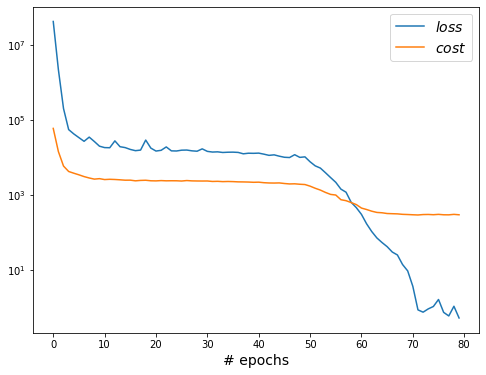

In [10]:
""" plot the history of loss and cost """
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(model.loss_history, label='$loss$')
ax.plot(model.cost_history, label='$cost$')
ax.set_xlabel('# epochs', fontsize=14)
ax.set_yscale('log')
plt.legend(fontsize=14)
plt.show()

""" save model for future use """
torch.save(model.Vnet.state_dict(), './saved-models/pendulum_model_SOC.chk')

---
## Model Testing and Results

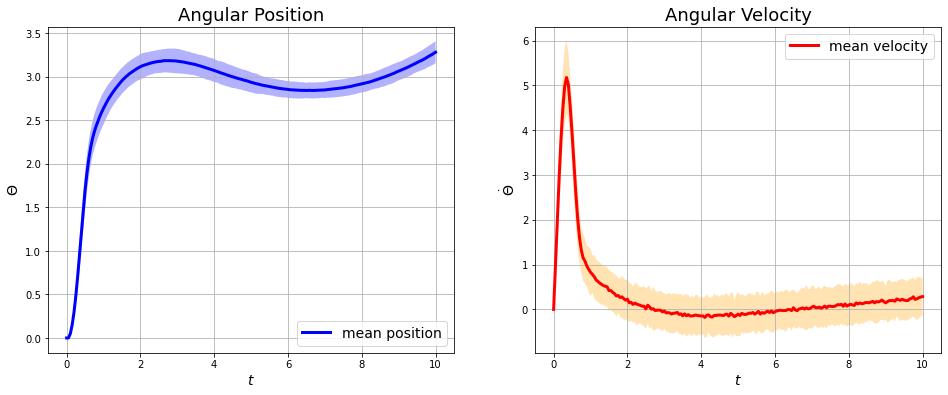

In [11]:
""" testing the model on a batch of test episodes """
n_episode = 128
t_pred, X_pred, v_pred, u_pred, loss, cost = model.predict(n_episode=n_episode)

""" plot the average pendulum angular position and velocity for the test episodes
as well as 95% confidence intervals """
theta_avg = X_pred[...,0].mean(axis=0)
theta_std = X_pred[...,0].std(axis=0)
thdot_avg = X_pred[...,1].mean(axis=0)
thdot_std = X_pred[...,1].std(axis=0)

fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
ax0.plot(t_pred[0,:], theta_avg, 'b-', linewidth=3, label='mean position')
ax0.fill_between(t_pred[0,:], theta_avg-1.96*theta_std, theta_avg+1.96*theta_std, facecolor='blue', alpha=0.3)
ax0.set_title('Angular Position', fontsize=18)
ax0.set_xlabel('$t$', fontsize=14)
ax0.set_ylabel('$\Theta$', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.grid('major')

ax1 = fig.add_subplot(122)
ax1.plot(t_pred[0,:], thdot_avg, 'r-', linewidth=3, label='mean velocity')
ax1.fill_between(t_pred[0,:], thdot_avg-1.96*thdot_std, thdot_avg+1.96*thdot_std, facecolor='orange', alpha=0.3)
ax1.set_title('Angular Velocity', fontsize=18)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$\dot{\Theta}$', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.grid('major')
plt.show()

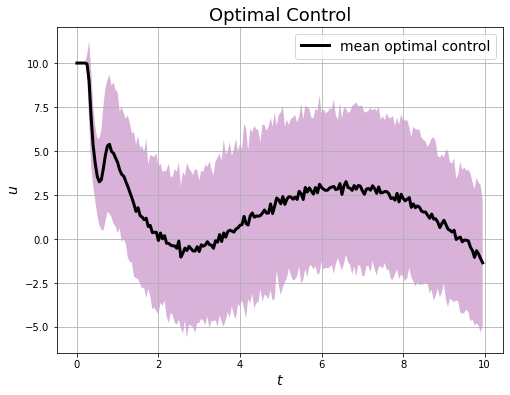

In [12]:
""" plot the average optimal control for the test episodes
as well as 95% confidence intervals """
u_avg = u_pred.mean(axis=0)
u_std = u_pred.std(axis=0)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(t_pred[0,:-1], u_avg, 'k-', linewidth=3, label='mean optimal control')
ax.fill_between(t_pred[0,:-1], u_avg-1.96*u_std, u_avg+1.96*u_std, facecolor='purple', alpha=0.3)
ax.set_title('Optimal Control', fontsize=18)
ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$u$', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.grid('major')
plt.show()

### Online inference using OpenAI gym environment
Trained model can be used for **online inference**. Here, we load the `StochPendulum-v0` gym environment to emulate the process. It generates the observations for each state (pendulum position and velocity), takes the action (optimal control) from the model and generates next state and reward. This will repeat for a certain period of time or until it reaches the end of the episode.

In [13]:
""" load the pre-trained model """
model.Vnet.load_state_dict(torch.load('./saved-models/pendulum-model.chk', map_location=model.device))
model.Vnet.eval()

dt = cfg.T_terminal / cfg.n_timestep
sigma = cfg.sigma[1]
kwargs = {'sigma': sigma, 'dt': dt}
# eval_env = wrap_env(gym.make('StochPendulum-v0', **kwargs))        # wrapper to create a video and save to disk
eval_env = gym.make('StochPendulum-v0', **kwargs)

t = 0
episodic_reward = 0
""" get the state from the gym env and reshape it before giving to the model """
prev_state = eval_env.reset()
torch_t = torch.Tensor( np.array( [[t]] ) ).to(cfg.device)
prev_state = np.array( [[prev_state[0], prev_state[1]]] )
torch_prev_state = torch.Tensor(prev_state).requires_grad_(True).to(cfg.device)
_, z = model.net_v_z(torch_t, torch_prev_state)   # model prediction on V_x

for n in range(cfg.n_timestep):
    eval_env.render()
    action = model.env.optimal_control(z)         # compute the optimal control
    """ give action to the gym env and recieve the new state as well as the reward """
    state, reward, done, info = eval_env.step(action.detach().numpy()[0])
    episodic_reward += -reward                    # reward = -cost
    t += dt
    prev_state = np.array( [[state[0], state[1]]] )
    if done:
        print(f'Episode finished after {t:.3f} seconds with cost = {episodic_reward:.3f}')
        break
    torch_t = torch.Tensor(np.array( [[t]] )).to(cfg.device)
    torch_prev_state = torch.Tensor(prev_state).requires_grad_(True).to(cfg.device)
    _, z = model.net_v_z(torch_t, torch_prev_state)
eval_env.close()
# show_video('path_to_file')                       # use this method if the video is saved to disk

Episode finished after 10.000 seconds with cost = 195.328
